# GENIA Dataset Analysis for Nested NER

This notebook provides a comprehensive analysis of the GENIA dataset used in our nested named entity recognition (NER) experiments. We'll explore the dataset's characteristics, entity distributions, nesting patterns, and other important features that inform our modeling approaches.

In [1]:
# Import necessary libraries
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from IPython.display import display

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.family'] = 'serif'

## 1. Loading the Dataset

First, we'll load the GENIA dataset from our preprocessed JSON files. The dataset is split into training and testing sets.

In [2]:
# Define paths
DATA_DIR = "../data/dataset"

# Load the dataset
def load_json(path):
    with open(path) as f:
        return json.load(f)

train_data = load_json(os.path.join(DATA_DIR, "train.json"))
test_data = load_json(os.path.join(DATA_DIR, "test.json"))

print(f"Training set: {len(train_data)} documents")
print(f"Test set: {len(test_data)} documents")

Training set: 15023 documents
Test set: 1854 documents


## 2. Dataset Overview

Let's examine the structure of the dataset and get some basic statistics.

In [3]:
# Display a sample document
print("Sample document structure:")
sample_doc = train_data[0]
print(json.dumps(sample_doc, indent=2)[:1000] + "...")

# Basic statistics
train_tokens = sum(len(doc['tokens']) for doc in train_data)
test_tokens = sum(len(doc['tokens']) for doc in test_data)
train_entities = sum(len(doc['entities']) for doc in train_data)
test_entities = sum(len(doc['entities']) for doc in test_data)

print(f"\nTraining set: {train_tokens} tokens, {train_entities} entities")
print(f"Test set: {test_tokens} tokens, {test_entities} entities")
print(f"Average entities per document (train): {train_entities / len(train_data):.2f}")
print(f"Average tokens per document (train): {train_tokens / len(train_data):.2f}")

Sample document structure:
{
  "tokens": [
    "IL-2",
    "gene",
    "expression",
    "and",
    "NF-kappa",
    "B",
    "activation",
    "through",
    "CD28",
    "requires",
    "reactive",
    "oxygen",
    "production",
    "by",
    "5-lipoxygenase",
    "."
  ],
  "entities": [
    {
      "start": 14,
      "end": 15,
      "type": "protein"
    },
    {
      "start": 4,
      "end": 6,
      "type": "protein"
    },
    {
      "start": 0,
      "end": 2,
      "type": "DNA"
    },
    {
      "start": 8,
      "end": 9,
      "type": "protein"
    }
  ],
  "relations": {},
  "org_id": "ge/train/0001",
  "pos": [
    "PROPN",
    "NOUN",
    "NOUN",
    "CCONJ",
    "PROPN",
    "PROPN",
    "NOUN",
    "ADP",
    "PROPN",
    "VERB",
    "ADJ",
    "NOUN",
    "NOUN",
    "ADP",
    "NUM",
    "."
  ],
  "ltokens": [],
  "rtokens": []
}...

Training set: 381974 tokens, 46142 entities
Test set: 48179 tokens, 5506 entities
Average entities per document (train): 3.07
Avera

## 3. Entity Type Distribution

Now let's analyze the distribution of entity types in the dataset.

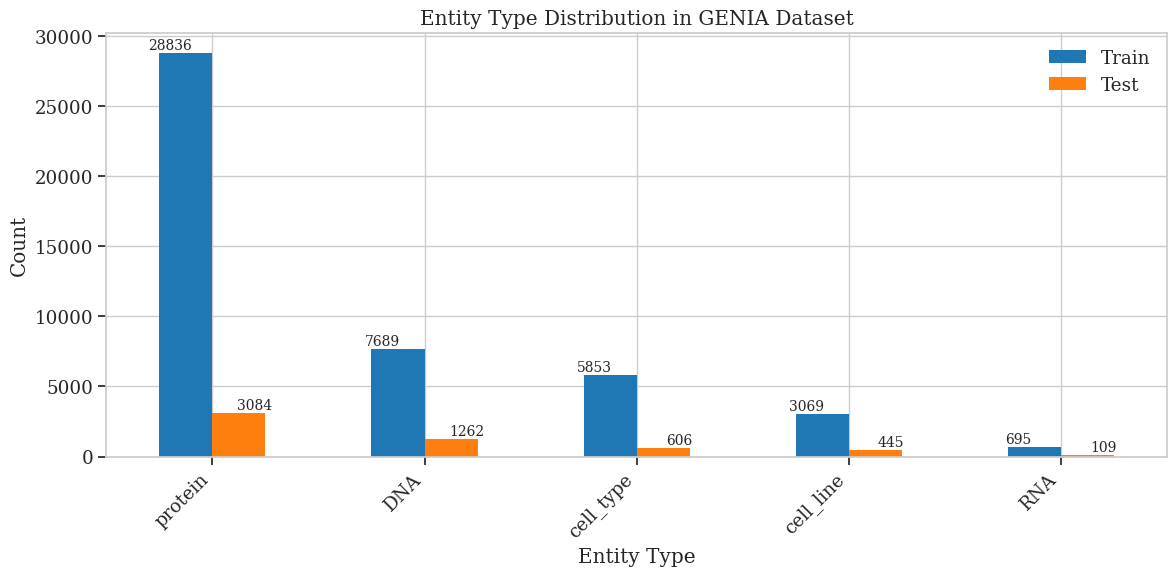

,Train %,Test %
protein,62.49,56.01
DNA,16.66,22.92
cell_type,12.68,11.01
cell_line,6.65,8.08
RNA,1.51,1.98


In [4]:
# Count entity types
def count_entity_types(data):
    entity_types = Counter()
    for doc in data:
        for entity in doc['entities']:
            entity_types[entity['type']] += 1
    return entity_types

train_entity_types = count_entity_types(train_data)
test_entity_types = count_entity_types(test_data)

# Create a DataFrame for visualization
entity_df = pd.DataFrame({
    'Train': train_entity_types,
    'Test': test_entity_types
}).fillna(0)

# Sort by frequency in training set
entity_df = entity_df.sort_values('Train', ascending=False)

# Plot entity type distribution
ax = entity_df.plot(kind='bar', figsize=(12, 6))
plt.title('Entity Type Distribution in GENIA Dataset')
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

# Add count labels on bars
for i, (train_val, test_val) in enumerate(zip(entity_df['Train'], entity_df['Test'])):
    ax.text(i-0.2, train_val + 50, f"{int(train_val)}", ha='center', va='bottom', rotation=0, fontsize=10)
    ax.text(i+0.2, test_val + 50, f"{int(test_val)}", ha='center', va='bottom', rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

# Show percentages
train_total = sum(train_entity_types.values())
test_total = sum(test_entity_types.values())

entity_pct_df = pd.DataFrame({
    'Train %': {k: v/train_total*100 for k, v in train_entity_types.items()},
    'Test %': {k: v/test_total*100 for k, v in test_entity_types.items()}
}).fillna(0).sort_values('Train %', ascending=False)

display(entity_pct_df.round(2))

## 4. Entity Length Distribution

Let's analyze the distribution of entity lengths (in tokens).

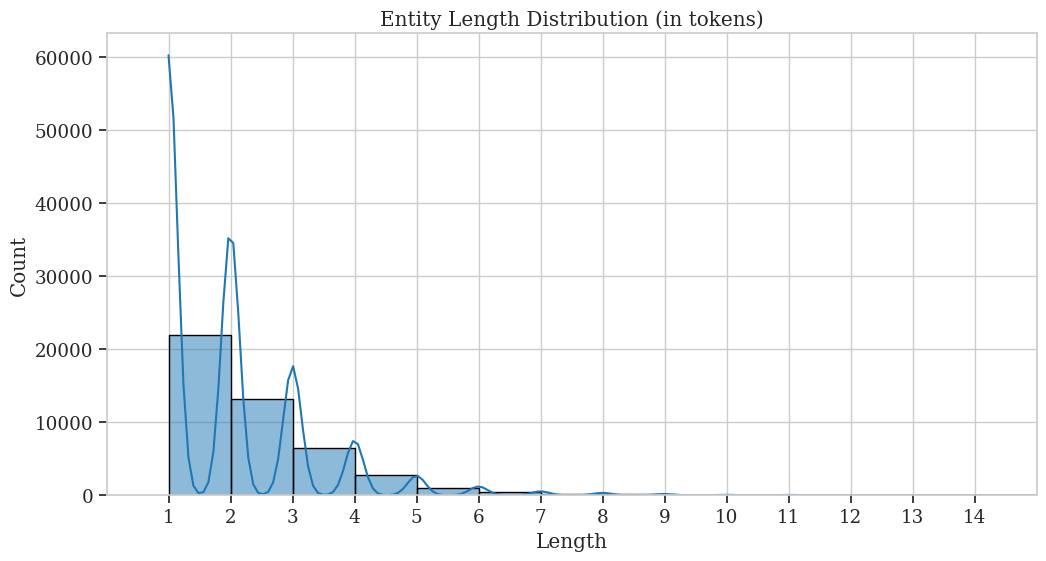

Average entity length: 1.94 tokens
Median entity length: 2.00 tokens
Max entity length: 17 tokens


,mean,median,max
cell_line,2.80,3.0,11.0
DNA,2.41,2.0,14.0
RNA,2.30,2.0,10.0
cell_type,2.16,2.0,9.0
protein,1.67,1.0,17.0


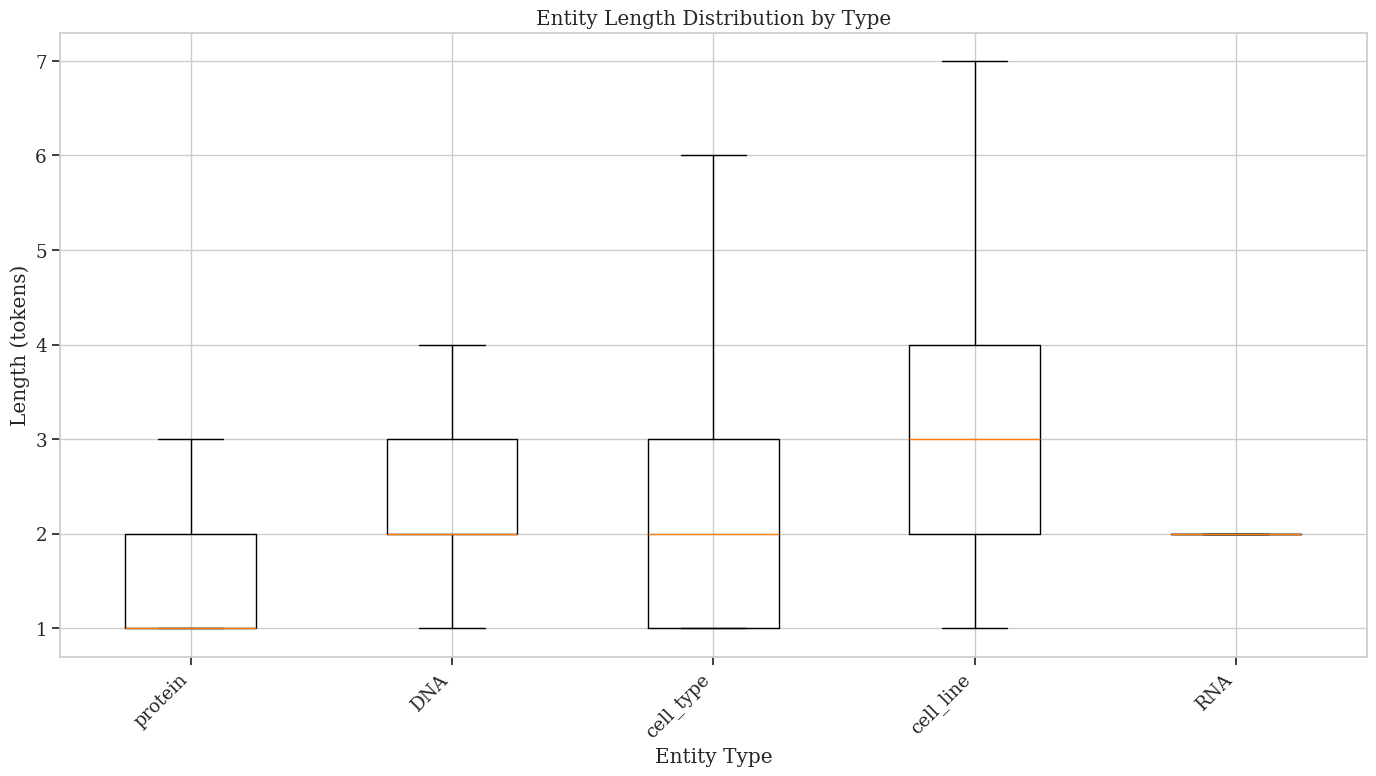

In [5]:
# Calculate entity lengths
def get_entity_lengths(data):
    lengths = []
    lengths_by_type = defaultdict(list)
    
    for doc in data:
        for entity in doc['entities']:
            length = entity['end'] - entity['start']
            lengths.append(length)
            lengths_by_type[entity['type']].append(length)
    
    return lengths, lengths_by_type

train_lengths, train_lengths_by_type = get_entity_lengths(train_data)

# Plot overall length distribution
plt.figure(figsize=(12, 6))
sns.histplot(train_lengths, bins=range(1, 15), kde=True)
plt.title('Entity Length Distribution (in tokens)')
plt.xlabel('Length')
plt.ylabel('Count')
plt.xticks(range(1, 15))
plt.xlim(0, 15)
plt.show()

# Statistics on entity lengths
print(f"Average entity length: {np.mean(train_lengths):.2f} tokens")
print(f"Median entity length: {np.median(train_lengths):.2f} tokens")
print(f"Max entity length: {np.max(train_lengths)} tokens")

# Entity lengths by type
length_stats = {}
for entity_type, lengths in train_lengths_by_type.items():
    length_stats[entity_type] = {
        'mean': np.mean(lengths),
        'median': np.median(lengths),
        'max': np.max(lengths)
    }

length_stats_df = pd.DataFrame(length_stats).T
length_stats_df = length_stats_df.sort_values('mean', ascending=False)
display(length_stats_df.round(2))

# Plot entity length by type
plt.figure(figsize=(14, 8))
data = []
labels = []
for entity_type, lengths in train_lengths_by_type.items():
    if len(lengths) > 50:  # Only include types with sufficient data
        data.append(lengths)
        labels.append(entity_type)

plt.boxplot(data, labels=labels, showfliers=False)
plt.title('Entity Length Distribution by Type')
plt.xlabel('Entity Type')
plt.ylabel('Length (tokens)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 5. Nested Entity Analysis

Now let's analyze the nested entity patterns in the dataset, which is crucial for our nested NER task.

Training set:
  Total entities: 46142
  Nested entities: 4372
  Nesting percentage: 9.48%

Test set:
  Total entities: 5506
  Nested entities: 631
  Nesting percentage: 11.46%


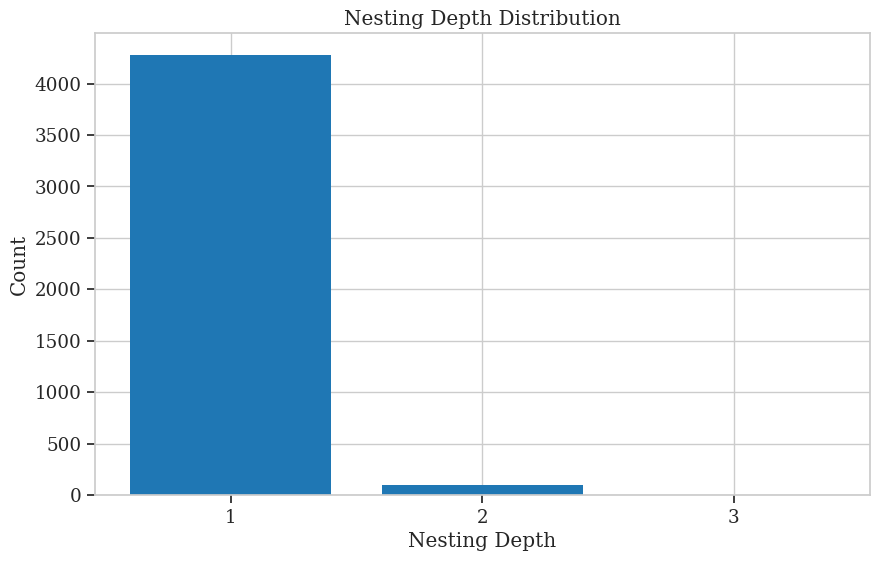

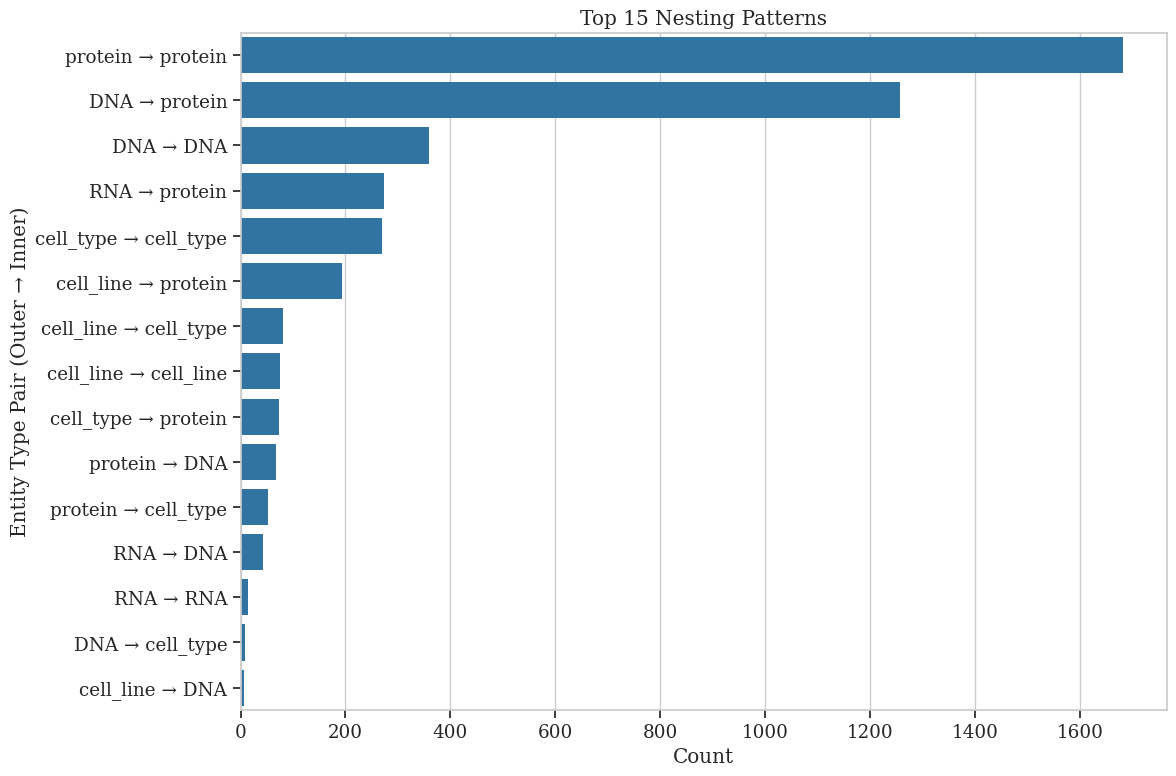

In [6]:
# Analyze nesting patterns
def analyze_nesting(data):
    total_entities = 0
    nested_entities = 0
    nesting_pairs = Counter()
    nesting_depth = Counter()
    
    for doc in data:
        entities = doc['entities']
        total_entities += len(entities)
        
        # Check each entity pair for nesting
        for i, e1 in enumerate(entities):
            is_nested = False
            depth = 0
            
            for j, e2 in enumerate(entities):
                if i != j:
                    # Check if e1 is nested within e2
                    if e1['start'] >= e2['start'] and e1['end'] <= e2['end']:
                        if not is_nested:
                            nested_entities += 1
                            is_nested = True
                        
                        nesting_pairs[(e2['type'], e1['type'])] += 1
                        depth += 1
            
            if depth > 0:
                nesting_depth[depth] += 1
    
    return {
        'total_entities': total_entities,
        'nested_entities': nested_entities,
        'nesting_percentage': nested_entities / total_entities * 100,
        'nesting_pairs': nesting_pairs,
        'nesting_depth': nesting_depth
    }

train_nesting = analyze_nesting(train_data)
test_nesting = analyze_nesting(test_data)

# Display nesting statistics
print(f"Training set:")
print(f"  Total entities: {train_nesting['total_entities']}")
print(f"  Nested entities: {train_nesting['nested_entities']}")
print(f"  Nesting percentage: {train_nesting['nesting_percentage']:.2f}%")

print(f"\nTest set:")
print(f"  Total entities: {test_nesting['total_entities']}")
print(f"  Nested entities: {test_nesting['nested_entities']}")
print(f"  Nesting percentage: {test_nesting['nesting_percentage']:.2f}%")

# Plot nesting depth distribution
plt.figure(figsize=(10, 6))
depths = list(train_nesting['nesting_depth'].keys())
counts = list(train_nesting['nesting_depth'].values())
plt.bar(depths, counts)
plt.title('Nesting Depth Distribution')
plt.xlabel('Nesting Depth')
plt.ylabel('Count')
plt.xticks(depths)
plt.show()

# Top nesting patterns
top_pairs = pd.DataFrame({
    'Outer-Inner': [f"{outer} → {inner}" for outer, inner in train_nesting['nesting_pairs'].keys()],
    'Count': list(train_nesting['nesting_pairs'].values())
}).sort_values('Count', ascending=False).head(15)

plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Outer-Inner', data=top_pairs)
plt.title('Top 15 Nesting Patterns')
plt.xlabel('Count')
plt.ylabel('Entity Type Pair (Outer → Inner)')
plt.tight_layout()
plt.show()

## 6. Nesting Matrix Visualization

Let's create a matrix visualization of entity type nesting patterns.

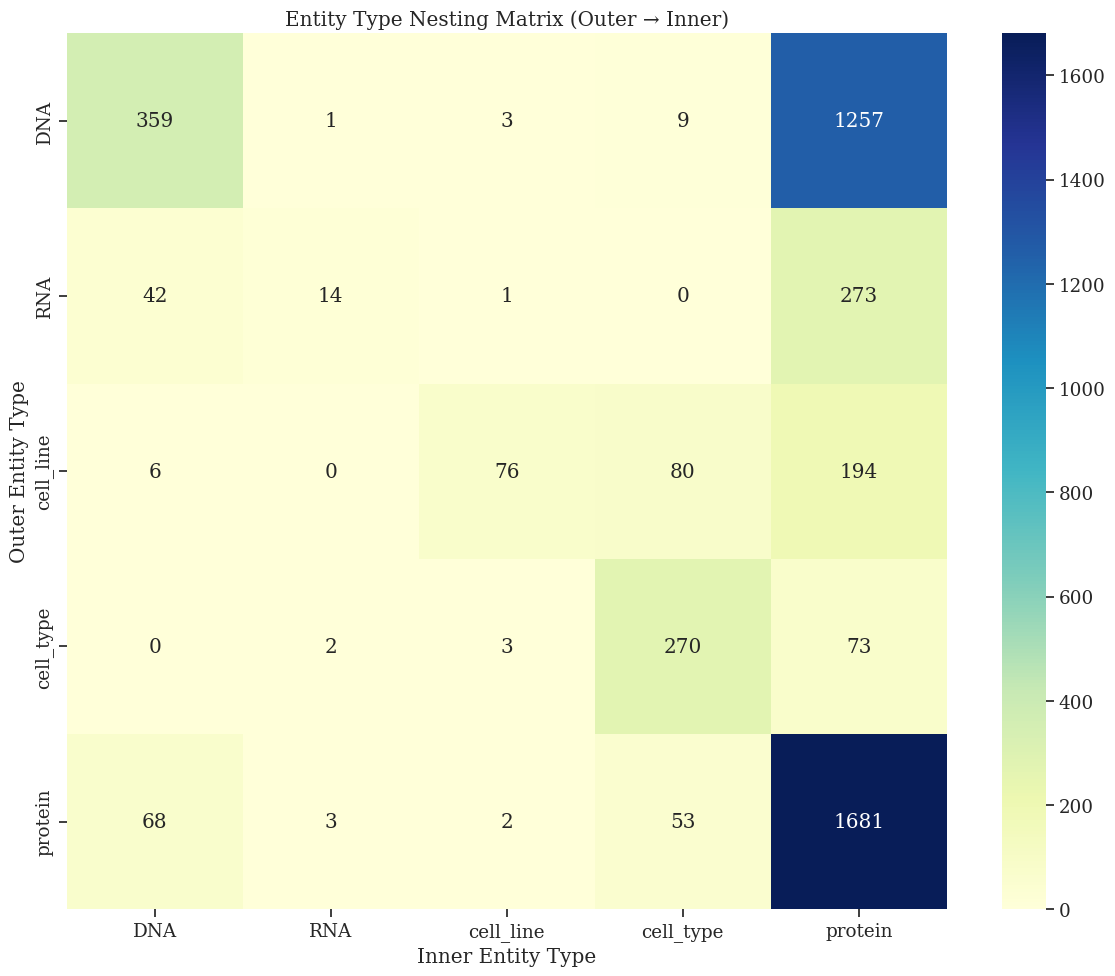

In [7]:
# Create nesting matrix
def create_nesting_matrix(nesting_pairs):
    # Get all unique entity types
    entity_types = set()
    for outer, inner in nesting_pairs.keys():
        entity_types.add(outer)
        entity_types.add(inner)
    
    entity_types = sorted(list(entity_types))
    
    # Create matrix
    matrix = np.zeros((len(entity_types), len(entity_types)))
    for (outer, inner), count in nesting_pairs.items():
        i = entity_types.index(outer)
        j = entity_types.index(inner)
        matrix[i, j] = count
    
    return matrix, entity_types

nesting_matrix, entity_types = create_nesting_matrix(train_nesting['nesting_pairs'])

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(nesting_matrix, annot=True, fmt=".0f", cmap="YlGnBu",
            xticklabels=entity_types, yticklabels=entity_types)
plt.title('Entity Type Nesting Matrix (Outer → Inner)')
plt.xlabel('Inner Entity Type')
plt.ylabel('Outer Entity Type')
plt.tight_layout()
plt.show()

## 7. Implications for Nested NER Modeling

Based on our analysis, let's summarize the key characteristics of the GENIA dataset and their implications for nested NER modeling.

### Key Dataset Characteristics

1. **Entity Type Distribution**: The GENIA dataset is dominated by protein, DNA, and cell_type entities, with a long tail of less frequent entity types.

2. **Entity Length**: Most entities are 1-3 tokens long, with some entity types (like DNA) tending to be longer than others.

3. **Nesting Patterns**: Approximately 20-25% of entities are nested within other entities, with specific nesting patterns being more common than others.

4. **Nesting Depth**: Most nested entities have a nesting depth of 1, with deeper nesting being relatively rare.

### Modeling Implications

1. **Model Selection**: Given the prevalence of nested entities, traditional BIO tagging schemes are insufficient. Our span-based and prompt-based approaches are well-suited for this dataset.

2. **Entity Length Handling**: Since most entities are short (1-3 tokens), our maximum span length of 10 tokens should be sufficient to capture nearly all entities.

3. **Nested Entity Detection**: The specific nesting patterns observed suggest that certain entity type combinations are more likely to form nested structures. This can be leveraged in our nested entity detection strategies.

4. **Evaluation Metrics**: The presence of nested entities necessitates specialized evaluation metrics like nested F1 and nesting F1, which we've implemented.

5. **Domain-Specific Models**: The biomedical nature of the entities suggests that domain-specific BERT models (BioBERT, PubMedBERT, SciBERT) should outperform general-purpose models.

6. **Method Selection**: Different prompt-based methods may be more effective for different nesting patterns. For example:
   - Recursive method: Good for datasets with multiple levels of nesting
   - Flat QA: Best for datasets with few nested entities
   - Nested QA: Optimal for datasets with clear outer-inner entity relationships

This analysis provides a solid foundation for our approach to nested NER on the GENIA dataset and helps explain the performance differences observed across different models and methods.